# Inventory Management Model

```{include} _admonition/gpu.md
```


This lecture provides a JAX implementation of a model in [Dynamic Programming](https://dp.quantecon.org/).

We require the following library to be installed.

In [1]:
!pip install --upgrade quantecon

## A model with constant discounting


We study a firm where a manager tries to maximize shareholder value.

To simplify the problem, we  assume that the firm only sells one product.

Letting $\pi_t$ be profits at time $t$ and $r > 0$ be the interest rate, the value of the firm is

$$
    V_0 = \sum_{t \geq 0} \beta^t \pi_t
    \qquad
    \text{ where }
    \quad \beta := \frac{1}{1+r}.
$$

Suppose the firm faces exogenous demand process $(D_t)_{t \geq 0}$.

We assume $(D_t)_{t \geq 0}$ is IID with common distribution $\phi \in (Z_+)$.

Inventory $(X_t)_{t \geq 0}$ of the product obeys

$$
    X_{t+1} = f(X_t, D_{t+1}, A_t)
    \qquad
    \text{where}
    \quad
    f(x,a,d) := (x - d)\vee 0 + a.
$$

The term $A_t$ is units of stock ordered this period, which take one period to
arrive.

We assume that the firm can store at most $K$ items at one time.

Profits are given by

$$
    \pi_t := X_t \wedge D_{t+1} - c A_t - \kappa 1\{A_t > 0\}.
$$

We take the minimum of current stock and demand because orders in excess of
inventory are assumed to be lost rather than back-filled.

Here $c$ is unit product cost and $\kappa$ is a fixed cost of ordering inventory.


We can map our inventory problem into a dynamic program with state space
$X := \{0, \ldots, K\}$ and action space $A := X$.

The feasible correspondence $\Gamma$ is

$$
\Gamma(x) := \{0, \ldots, K - x\},
$$

which represents the set of feasible orders when the current inventory
state is $x$.

The reward function is expected current profits, or

$$
    r(x, a)  := \sum_{d \geq 0} (x \wedge d) \phi(d)
        - c a - \kappa 1\{a > 0\}.
$$

The stochastic kernel (i.e., state-transition probabilities) from the set of feasible state-action pairs is

$$
    P(x, a, x') := P\{ f(x, a, D) = x' \}
    \qquad \text{when} \quad
    D \sim \phi.
$$

When discounting is constant, the Bellman equation takes the form

```{math}
:label: inventory_ssd_v1
    v(x)
    = \max_{a \in \Gamma(x)} \left\{
        r(x, a)
        + \beta
        \sum_{d \geq 0} v(f(x, a, d)) \phi(d)
    \right\}
```

## Time varing discount rates

We wish to consider a more sophisticated model with time-varying discounting.

This time variation accommodates non-constant interest rates.

To this end, we replace the constant $\beta$ in
{eq}`inventory_ssd_v1` with a stochastic process $(\beta_t)$ where

* $\beta_t = 1/(1+r_t)$ and
* $r_t$ is the interest rate at time $t$

We suppose that the dynamics can be expressed as $\beta_t = \beta(Z_t)$, where the exogenous process $(Z_t)_{t \geq 0}$ is a Markov chain
on $Z$ with Markov matrix $Q$.

After relabeling inventory $X_t$ as $Y_t$ and $x$ as $y$, the Bellman equation becomes

$$
    v(y, z) = \max_{a \in \Gamma(x)} B((y, z), a, v)
$$

where

```{math}
:label: inventory_ssd_b1
    B((y, z), a, v)
    =
        r(y, a)
        + \beta(z)
        \sum_{d, \, z'} v(f(y, a, d), z') \phi(d) Q(z, z').
```

We set

$$
    R(y, a, y')
        := P\{f(y, a, d) = y'\} \quad \text{when} \quad D \sim \phi,
$$

Now $R(y, a, y')$ is the probability of realizing next period inventory level
$y'$ when the current level is $y$ and the action is $a$.

Hence we can rewrite {eq}`inventory_ssd_b1` as

$$
    B((y, z), a, v)
    =  r(y, a)
        + \beta(z)
        \sum_{y', z'} v(y', z') Q(z, z') R(y, a, y') .
$$

Let's begin with the following imports

In [2]:
import quantecon as qe
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import time
from numba import njit, prange

Let's check the GPU we are running

In [3]:
!nvidia-smi

Mon Sep  4 03:00:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    42W / 300W |      0MiB / 16160MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We will use 64 bit floats with JAX in order to increase the precision.

In [4]:
jax.config.update("jax_enable_x64", True)

Let's define a model to represent the inventory management.

In [5]:
# NamedTuple Model
Model = namedtuple("Model", ("c", "κ", "p", "z_vals", "Q"))

We need the following successive approximation function.

In [6]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

In [7]:
@jax.jit
def demand_pdf(p, d):
    return (1 - p)**d * p

In [8]:
K = 100
D_MAX = 101

Let's define a function to create an inventory model using the given parameters.

In [9]:
def create_sdd_inventory_model(
        ρ=0.98, ν=0.002, n_z=100, b=0.97,          # Z state parameters
        c=0.2, κ=0.8, p=0.6,                       # firm and demand parameters
        use_jax=True):
    mc = qe.tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values + b, mc.P
    if use_jax:
        z_vals, Q = map(jnp.array, (z_vals, Q))
    return Model(c=c, κ=κ, p=p, z_vals=z_vals, Q=Q)

Here's the function `B` on the right-hand side of the Bellman equation.

In [10]:
@jax.jit
def B(x, i_z, a, v, model):
    """
    The function B(x, z, a, v) = r(x, a) + β(z) Σ_x′ v(x′) P(x, a, x′).
    """
    c, κ, p, z_vals, Q = model
    z = z_vals[i_z]
    d_vals = jnp.arange(D_MAX)
    ϕ_vals = demand_pdf(p, d_vals)
    revenue = jnp.sum(jnp.minimum(x, d_vals)*ϕ_vals)
    profit = revenue - c * a - κ * (a > 0)
    v_R = jnp.sum(v[jnp.maximum(x - d_vals, 0) + a].T * ϕ_vals, axis=1)
    cv = jnp.sum(v_R*Q[i_z])
    return profit + z * cv

We need to vectorize this function so that we can use it efficiently in JAX.

We apply a sequence of `vmap` operations to vectorize appropriately in each
argument.

In [11]:
B_vec_a = jax.vmap(B, in_axes=(None, None, 0, None, None))

In [12]:
@jax.jit
def B2(x, i_z, v, model):
    """
    The function B(x, z, a, v) = r(x, a) + β(z) Σ_x′ v(x′) P(x, a, x′).
    """
    c, κ, p, z_vals, Q = model
    a_vals = jnp.arange(K)
    res = B_vec_a(x, i_z, a_vals, v, model)
    return jnp.where(a_vals < K - x + 1, res, -jnp.inf)

In [13]:
B2_vec_z = jax.vmap(B2, in_axes=(None, 0, None, None))
B2_vec_z_x = jax.vmap(B2_vec_z, in_axes=(0, None, None, None))

Next we define the Bellman operator.

In [14]:
@jax.jit
def T(v, model):
    """The Bellman operator."""
    c, κ, p, z_vals, Q = model
    i_z_range = jnp.arange(len(z_vals))
    x_range = jnp.arange(K + 1)
    res = B2_vec_z_x(x_range, i_z_range, v, model)
    return jnp.max(res, axis=2)

The following function computes a v-greedy policy.

In [15]:
@jax.jit
def get_greedy(v, model):
    """Get a v-greedy policy.  Returns a zero-based array."""
    c, κ, p, z_vals, Q  = model
    i_z_range = jnp.arange(len(z_vals))
    x_range = jnp.arange(K + 1)
    res = B2_vec_z_x(x_range, i_z_range, v, model)
    return jnp.argmax(res, axis=2)

Here's code to solve the model using value function iteration.

In [16]:
def solve_inventory_model(v_init, model):
    """Use successive_approx to get v_star and then compute greedy."""
    v_star = successive_approx(lambda v: T(v, model), v_init, verbose=True)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

Now let's create an instance and solve it.

In [17]:
model = create_sdd_inventory_model()
c, κ, p, z_vals, Q = model
n_z = len(z_vals)
v_init = jnp.zeros((K + 1, n_z), dtype=float)

In [18]:
in_time = time.time()
v_star, σ_star = solve_inventory_model(v_init, model)
jax_time = time.time() - in_time

Completed iteration 25 with error 0.5613828428334706.
Completed iteration 50 with error 0.3776464347688062.
Completed iteration 75 with error 0.2272706235969011.
Completed iteration 100 with error 0.12872204940708798.


Completed iteration 125 with error 0.06744149371262154.
Completed iteration 150 with error 0.030374639547666504.
Completed iteration 175 with error 0.01423099032950148.
Completed iteration 200 with error 0.007396776219316337.
Completed iteration 225 with error 0.003912238304586424.


Completed iteration 250 with error 0.0020680914166604225.
Completed iteration 275 with error 0.001092307533355097.
Completed iteration 300 with error 0.0005766427105982075.
Completed iteration 325 with error 0.0003043321707139057.
Completed iteration 350 with error 0.0001605907367547843.


Completed iteration 375 with error 8.473334524694565e-05.
Completed iteration 400 with error 4.4706045166265085e-05.
Completed iteration 425 with error 2.3586619946058818e-05.
Completed iteration 450 with error 1.2443945941242873e-05.
Completed iteration 475 with error 6.565178331641164e-06.


Completed iteration 500 with error 3.463639430378862e-06.
Completed iteration 525 with error 1.827332347659194e-06.
Terminated successfully in 550 iterations.


In [19]:
z_mc = qe.MarkovChain(Q, z_vals)

In [20]:
def sim_inventories(ts_length, X_init=0):
    """Simulate given the optimal policy."""
    global p, z_mc
    i_z = z_mc.simulate_indices(ts_length, init=1)
    X = np.zeros(ts_length, dtype=np.int32)
    X[0] = X_init
    rand = np.random.default_rng().geometric(p=p, size=ts_length-1) - 1
    for t in range(ts_length-1):
        X[t+1] = np.maximum(X[t] - rand[t], 0) + σ_star[X[t], i_z[t]]
    return X, z_vals[i_z]

In [21]:
def plot_ts(ts_length=400, fontsize=10):
    X, Z = sim_inventories(ts_length)
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))

    ax = axes[0]
    ax.plot(X, label=r"$X_t$", alpha=0.7)
    ax.set_xlabel(r"$t$", fontsize=fontsize)
    ax.set_ylabel("inventory", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, np.max(X)+3)

    # calculate interest rate from discount factors
    r = (1 / Z) - 1

    ax = axes[1]
    ax.plot(r, label=r"$r_t$", alpha=0.7)
    ax.set_xlabel(r"$t$", fontsize=fontsize)
    ax.set_ylabel("interest rate", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)

    plt.tight_layout()
    plt.show()

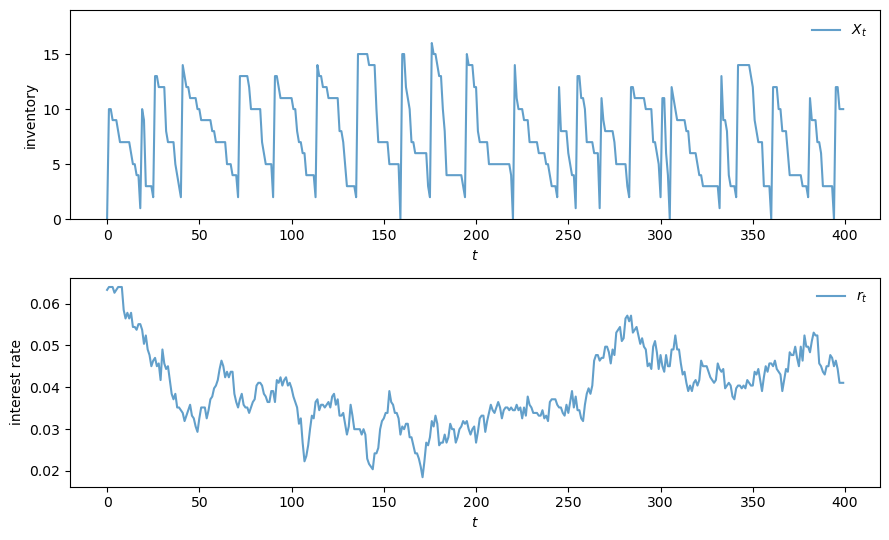

In [22]:
plot_ts()

## Numba implementation


Let's try the same operations in Numba in order to compare the speed.

In [23]:
@njit
def demand_pdf_numba(p, d):
    return (1 - p)**d * p

@njit
def B_numba(x, i_z, a, v, model):
    """
    The function B(x, z, a, v) = r(x, a) + β(z) Σ_x′ v(x′) P(x, a, x′).
    """
    c, κ, p, z_vals, Q = model
    z = z_vals[i_z]
    d_vals = np.arange(D_MAX)
    ϕ_vals = demand_pdf_numba(p, d_vals)
    revenue = np.sum(np.minimum(x, d_vals)*ϕ_vals)
    profit = revenue - c * a - κ * (a > 0)
    v_R = np.sum(v[np.maximum(x - d_vals, 0) + a].T * ϕ_vals, axis=1)
    cv = np.sum(v_R*Q[i_z])
    return profit + z * cv


@njit(parallel=True)
def T_numba(v, model):
    """The Bellman operator."""
    c, κ, p, z_vals, Q = model
    new_v = np.empty_like(v)
    for i_z in prange(len(z_vals)):
        for x in prange(K+1):
            v_1 = np.array([B_numba(x, i_z, a, v, model)
                             for a in range(K-x+1)])
            new_v[x, i_z] = np.max(v_1)
    return new_v


@njit(parallel=True)
def get_greedy_numba(v, model):
    """Get a v-greedy policy.  Returns a zero-based array."""
    c, κ, p, z_vals, Q = model
    n_z = len(z_vals)
    σ_star = np.zeros((K+1, n_z), dtype=np.int32)
    for i_z in prange(n_z):
        for x in range(K+1):
            v_1 = np.array([B_numba(x, i_z, a, v, model)
                             for a in range(K-x+1)])
            σ_star[x, i_z] = np.argmax(v_1)
    return σ_star



def solve_inventory_model_numba(v_init, model):
    """Use successive_approx to get v_star and then compute greedy."""
    v_star = successive_approx(lambda v: T_numba(v, model), v_init, verbose=True)
    σ_star = get_greedy_numba(v_star, model)
    return v_star, σ_star

In [24]:
model = create_sdd_inventory_model(use_jax=False)
c, κ, p, z_vals, Q  = model
n_z = len(z_vals)
v_init = np.zeros((K + 1, n_z), dtype=float)

In [25]:
in_time = time.time()
v_star_numba, σ_star_numba = solve_inventory_model_numba(v_init, model)
nb_time = time.time() - in_time

Completed iteration 25 with error 0.5613828428334706.


Completed iteration 50 with error 0.37764643476879556.


Completed iteration 75 with error 0.22727062359689398.


Completed iteration 100 with error 0.12872204940708798.


Completed iteration 125 with error 0.06744149371262864.


Completed iteration 150 with error 0.030374639547666504.


Completed iteration 175 with error 0.01423099032948727.


Completed iteration 200 with error 0.007396776219316337.


Completed iteration 225 with error 0.003912238304593529.


Completed iteration 250 with error 0.002068091416653317.


Completed iteration 275 with error 0.0010923075333622023.


Completed iteration 300 with error 0.0005766427105911021.


Completed iteration 325 with error 0.0003043321707281166.


Completed iteration 350 with error 0.00016059073676188973.


Completed iteration 375 with error 8.473334525405107e-05.


Completed iteration 400 with error 4.470604518047594e-05.


Completed iteration 425 with error 2.3586619960269672e-05.


Completed iteration 450 with error 1.2443945934137446e-05.


Completed iteration 475 with error 6.565178331641164e-06.


Completed iteration 500 with error 3.4636394445897167e-06.


Completed iteration 525 with error 1.827332347659194e-06.


Terminated successfully in 550 iterations.


Let's verify that the Numba and JAX implementations converge to the same solution.

In [26]:
np.allclose(v_star_numba, v_star)

True

Here's the speed comparison.

In [27]:
print(f"JAX vectorized implementation is {nb_time/jax_time} faster "
       "than Numba's parallel implementation")

JAX vectorized implementation is 754.2945353744977 faster than Numba's parallel implementation
